In [1]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

# # To show the interactive widgets 
# %matplotlib widget
# from Pyriod import Pyriod #!This hates me. So just using LK
# import warnings

# # Suppress warning from Astropy module 
# # astropy.stats used in Pyriod is no longer supported
# from astropy.utils.exceptions import AstropyDeprecationWarning
# warnings.filterwarnings("ignore", category=AstropyDeprecationWarning)

# # Suppress invalid value runtime warning from Astropy and Pyriod 
# warnings.filterwarnings("ignore", category=RuntimeWarning) 

# from IPython.display import Image

# import lightkurve as lk

1.7463655335664312 d


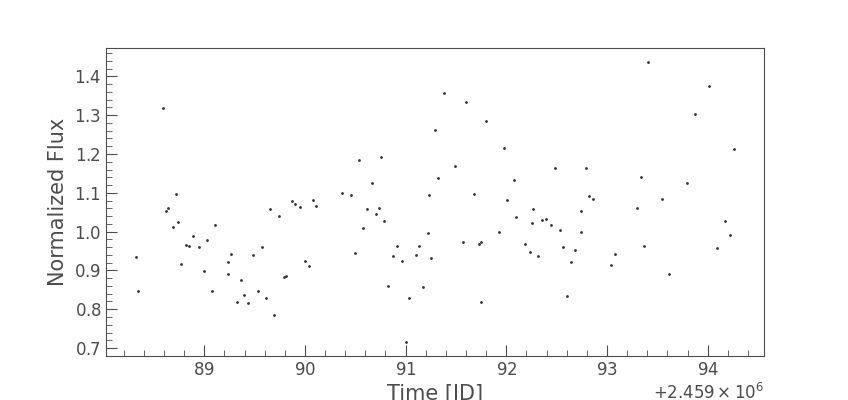

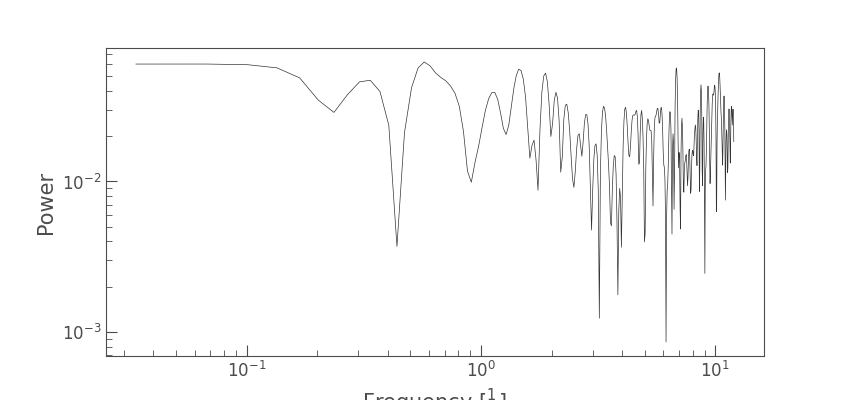

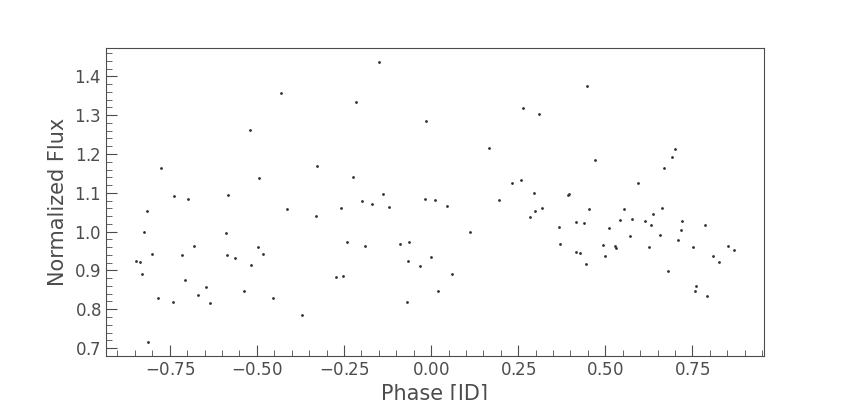

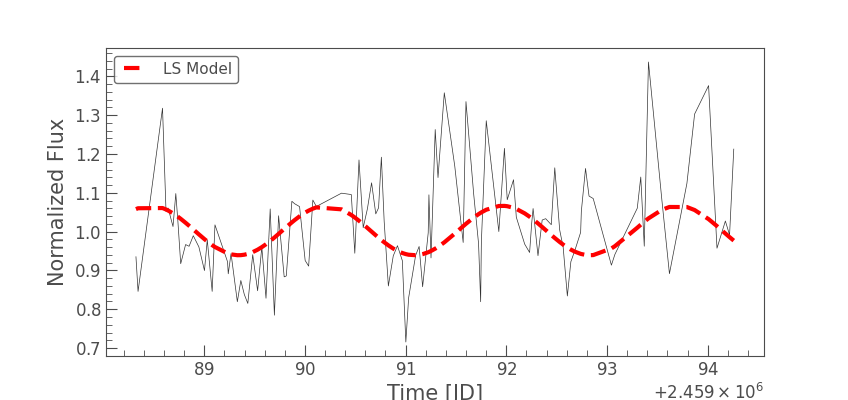

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightkurve as lk
import astropy.units as u
%matplotlib widget



def lcPlots(fName):
    """
    Uses LightKurve to make LC plots from just a filename of a csv with flux and Time cols.
    """
    data = pd.read_csv(fName)
    fluxes = data["flux"]
    times = data["Time"]

    fluxErrs = np.ones_like(fluxes)*1e-4 #lk needs errors

    lc =lk.LightCurve(data=None, time=times, flux=fluxes, flux_err=fluxErrs)
    lc = lc.normalize()
    lc.scatter()
    pg = lc.to_periodogram()

    pg.plot(scale="log")
    period = pg.period_at_max_power
    print(period)
    lc.fold(period).scatter()

    lcModel = pg.model(time=lc.time, frequency=pg.frequency_at_max_power)
    ax = lc.plot()
    lcModel.plot(ax=ax, lw=3, ls='--',c='red')
    return lcModel


fName = "./ 2001 UR124 Matches.csv"
lcm = lcPlots(fName=fName)



In [12]:
lcm.plot()
vars(lcm)


{'_required_columns_relax': False,
 '_required_columns': ['time', 'flux', 'flux_err'],
 '_masked': False,
 '_column_class': astropy.table.column.Column,
 'columns': <TableColumns names=('time','flux','flux_err')>,
 'formatter': <astropy.table.pprint.TableFormatter at 0x7ff582bba2f0>,
 '_copy_indices': True,
 '_init_indices': True,
 'primary_key': None,
 '_meta': {'FREQUENCY': <Quantity 0.57261781 1 / d>,
  'TARGETID': 'None LS Model',
  'LABEL': 'LS Model',
  'NORMALIZED': True},
 '_first_colname': 'time',
 '_required_columns_enabled': True,
 'pprint_exclude_names': <PprintIncludeExclude name=pprint_exclude_names value=None>,
 'pprint_include_names': <PprintIncludeExclude name=pprint_include_names value=None>,
 '_new_attributes_relax': False}